<a href="https://colab.research.google.com/github/a1coderxt/a1coderxt/blob/main/NewObject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
torch.__version__

'2.8.0+cu126'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
from google.colab import drive
drive.mount('/content/drive')
import torchvision
import torchvision.transforms as transforms
import os

data_path = "/content/drive/MyDrive/cifar10_data"

os.makedirs(data_path , exist_ok=True)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

download_flag = not os.path.exists(os.path.join(data_path , "cifar-10-batches-py"))

train_data = torchvision.datasets.CIFAR10(root=data_path,
                                     train=True,
                                     download=download_flag,
                                     transform=train_transform)

test_data = torchvision.datasets.CIFAR10(root=data_path,
                                    train=False,
                                    download=download_flag,
                                    transform=test_transform)
print(f"Train samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")
print(f"Classes: {train_data.classes[:10]}")

Mounted at /content/drive
Train samples: 50000
Test samples: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
# How many samples are there?
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(50000, 50000, 10000, 10000)

In [6]:
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Before Image Shape : torch.Size([3, 32, 32])
After Image shape : torch.Size([32, 32, 3])


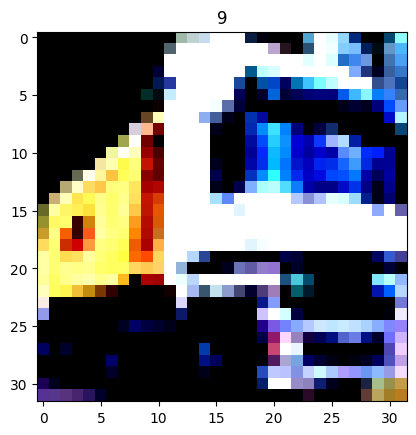

In [7]:
import matplotlib.pyplot as plt
image , label = train_data[1]
print(f"Before Image Shape : {image.shape}")

img_per = image.permute(1, 2, 0)
print(f"After Image shape : {img_per.shape}")

plt.imshow(img_per)
plt.title(label)
plt.show()

In [8]:
from torch.utils.data import DataLoader

# # Sirf 1000 training aur 500 testing images ka subset
# train_subset = Subset(train_data, list(range(5000)))
# test_subset = Subset(test_data, list(range(1000)))

# Turning into DataLoader
BATCH_SIZE = 32
NUM_WORKERS = 1
PIN_MEMORY = True

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True,
                              pin_memory=PIN_MEMORY
                              )

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False,
                             pin_memory=PIN_MEMORY
                             )


print(f"Both DataLoader : {train_dataloader}  | {test_dataloader}")
print(f"Lenght of train with batchs : {len(train_dataloader)} of batch {BATCH_SIZE}")
print(f"Lenght of test with batchs : {len(test_dataloader)} of batch {BATCH_SIZE}")

Both DataLoader : <torch.utils.data.dataloader.DataLoader object at 0x7f407f5a7b30>  | <torch.utils.data.dataloader.DataLoader object at 0x7f407f4797f0>
Lenght of train with batchs : 1563 of batch 32
Lenght of test with batchs : 313 of batch 32


In [9]:
image , label = next(iter(train_dataloader))
image.shape , label.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

Let's Create Model 0 using TinyVGG

In [10]:
import torch
import torch.nn as nn

class TinyVGG(nn.Module):
  def __init__(self,
               input_shape:int,
               hidden_units:int,
               output_shape:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(hidden_units),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2 , stride=2),
        nn.Dropout2d(0.1)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(hidden_units*2),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*2, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(hidden_units*2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2 , stride=2),
        nn.Dropout2d(0.1)
    )
    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units*2, out_channels=hidden_units*4, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(hidden_units*4),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units*4, out_channels=hidden_units*4, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(hidden_units*4),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2 , stride=2),
        nn.Dropout2d(0.2)
)


    self.classifier = nn.Sequential(
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(in_features=hidden_units*4, out_features=hidden_units*2),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(in_features=hidden_units*2, out_features=output_shape)
    )


  def forward(self , x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.conv_block_3(x)
    x = self.classifier(x)
    return x


model_0 = TinyVGG(input_shape=3,
                  hidden_units=128,
                  output_shape=10)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout2d(p=0.1, inplace=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_

In [11]:
def train_step(model: torch.nn.Module,
                dataloader: torch.utils.data.DataLoader,
                loss_fn:torch.nn.Module,
                optimizer:torch.optim.Optimizer,
                device=device):

  # put the model on train mode
  model.train()

  #Set train loss and train acc values
  train_loss , train_acc = 0 , 0

  # Loop through the dataloader or the data batches
  for X, y in dataloader:

    #Send data to target device
    X , y = X.to(device)  , y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2 . Calculate and accumalate the loss
    loss = loss_fn(y_pred , y)
    train_loss += loss.item()

    # 3 Optimizer zero grad
    optimizer.zero_grad()

    # 4 Loss backward
    loss.backward()

    # 5 optimizer step
    optimizer.step()


    # Calculate and accumalate the accuracy across all the batches
    y_pred_class = torch.argmax(y_pred , dim=1)
    train_acc += (y_pred_class == y).sum().item() / len(y_pred)

 # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss , train_acc

In [12]:
def test_step(model:torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              device=device):
  # Put on test mode
  model.eval()

  #Setup the test loss and test acc
  test_loss , test_acc = 0 , 0

  with torch.inference_mode():
    # Loop through the dataloader
    for X, y in dataloader:
      X , y = X.to(device) , y.to(device)

      # 1. Forward pass
      test_pred_logits  = model(X)

      # 2. Calculate and accumalate the loss
      loss =  loss_fn(test_pred_logits , y)
      test_loss += loss.item()

      # Calculate and accumulate the accuracy
      y_pred_label = test_pred_logits.argmax(dim=1)
      test_acc += ((y_pred_label == y).sum().item() / len(y_pred_label))


  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss , test_acc

In [13]:
from tqdm.auto import tqdm
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs : int = 5,
          device: torch.device = device):

  # Create empty result dictionary
  results = {
      "train_loss" : [],
      "train_acc" : [],
      "test_loss" : [],
      "test_acc" : []
  }

  # Now loop through training and testing step
  for epoch in tqdm(range(epochs)):
    train_loss , train_acc = train_step(model=model,
                                        dataloader=train_dataloader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device)

    test_loss , test_acc = test_step(model=model,
                                     dataloader=test_dataloader,
                                     loss_fn=loss_fn,
                                     device=device)

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

        # 4. Print out what's happening
    print(
    f"Epoch: {epoch+1} | "
    f"train_loss: {train_loss:.2f} | "
    f"train_acc: {train_acc:.2f} | "
    f"test_loss: {test_loss:.2f} | "
    f"test_acc: {test_acc:.2f}"
    )

  return results

In [14]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=128,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001 , weight_decay=1e-4)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.48 | train_acc: 0.45 | test_loss: 1.17 | test_acc: 0.57
Epoch: 2 | train_loss: 1.16 | train_acc: 0.59 | test_loss: 0.93 | test_acc: 0.66
Epoch: 3 | train_loss: 1.00 | train_acc: 0.65 | test_loss: 0.79 | test_acc: 0.72
Epoch: 4 | train_loss: 0.86 | train_acc: 0.70 | test_loss: 0.71 | test_acc: 0.77
Epoch: 5 | train_loss: 0.75 | train_acc: 0.75 | test_loss: 0.58 | test_acc: 0.81
Epoch: 6 | train_loss: 0.67 | train_acc: 0.78 | test_loss: 0.58 | test_acc: 0.80
Epoch: 7 | train_loss: 0.61 | train_acc: 0.80 | test_loss: 0.54 | test_acc: 0.82
Epoch: 8 | train_loss: 0.56 | train_acc: 0.81 | test_loss: 0.52 | test_acc: 0.83
Epoch: 9 | train_loss: 0.52 | train_acc: 0.83 | test_loss: 0.47 | test_acc: 0.84
Epoch: 10 | train_loss: 0.49 | train_acc: 0.84 | test_loss: 0.41 | test_acc: 0.86
Total training time: 382.086 seconds


In [15]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [16]:
from typing import Dict, List
import torch

def plot_loss_curves(results : Dict[str , List[float]]):

  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_acc = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15 ,7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs , loss , label="train_loss")
  plt.plot(epochs , test_loss , label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()


  plt.subplot(1, 2, 2)
  plt.plot(epochs , accuracy , label="train_acc")
  plt.plot(epochs , test_acc , label="test_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

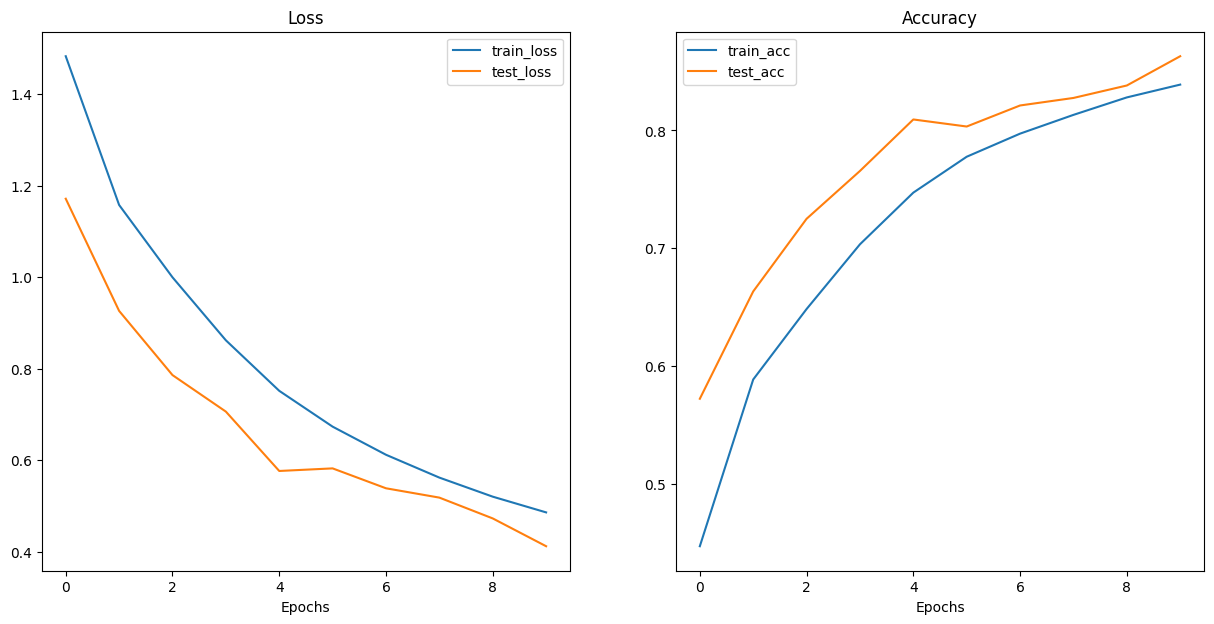

In [17]:
plot_loss_curves(model_0_results)

In [18]:
!nvidia-smi


Sat Aug 30 13:37:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   76C    P0             45W /   70W |     570MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [34]:
from pathlib import Path

from google.colab import drive
drive.mount("/content/drive")


custom_image_path = Path("/content/drive/MyDrive/aero.jpg")

if custom_image_path.is_file():
    print(f"Image found: {custom_image_path}")
else:
    print(f"Image not found at {custom_image_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Image found: /content/drive/MyDrive/aero.jpg


In [35]:
import torch
import torchvision
from torchvision.io import read_image

# Read the image as a tensor
custom_image = read_image(str(custom_image_path)).type(torch.float32)

custom_image = custom_image / 255
print(f"Custom image tensor : {custom_image}")
print(f"Custom image shape : {custom_image.shape}")


Custom image tensor : tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0039, 0.0039, 0.0039,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.7373, 0.7373, 0.7373,  ..., 0.6588, 0.6588, 0.6588],
         [0.7373, 0.7373, 0.7373,  ..., 0.6588, 0.6588, 0.6588],
         [0.7373, 0.7373, 0.7373,  ..., 0.6588, 0.6588, 0.6588]],

        [[0.4980, 0.4980, 0.5020,  ..., 0.5569, 0.5569, 0.5569],
         [0.5020, 0.5059, 0.5059,  ..., 0.5569, 0.5569, 0.5569],
         [0.5137, 0.5137, 0.5137,  ..., 0.5529, 0.5529, 0.5529],
         ...,
         [0.8039, 0.8039, 0.8039,  ..., 0.7765, 0.7765, 0.7765],
         [0.8039, 0.8039, 0.8039,  ..., 0.7765, 0.7765, 0.7765],
         [0.8039, 0.8039, 0.8039,  ..., 0.7765, 0.7765, 0.7765]],

        [[0.8039, 0.8039, 0.8078,  ..., 0.8392, 0.8392, 0.8392],
         [0.8000, 0.8039, 0.8039,  ..., 0.8392, 0.8392, 0.8392],
         [0.8078, 0.8078, 0.8078,  .

(np.float64(-0.5), np.float64(277.5), np.float64(181.5), np.float64(-0.5))

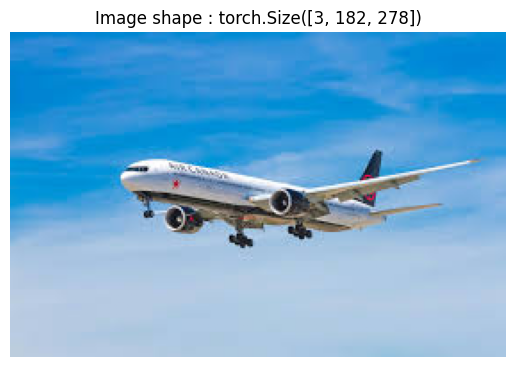

In [36]:
# plot the custom image
plt.imshow(custom_image.permute(1, 2, 0))
plt.title(f"Image shape : {custom_image.shape}")
plt.axis(False)

In [37]:
# lets create a transformed pipeline to this
custom_image_transform = transforms.Compose([transforms.Resize(size=(32, 32))])

custom_image_transformed = custom_image_transform(custom_image)

print(f"Original shape : {custom_image.shape}")
print(f"New shape : {custom_image_transformed.shape}")

Original shape : torch.Size([3, 182, 278])
New shape : torch.Size([3, 32, 32])


In [38]:
model_0.eval()
with torch.inference_mode():
  custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

  print(f"Custom image transformed shape : {custom_image_transformed.shape}")
  print(f"Unsqueeze transformed shape : {custom_image_transformed_with_batch_size.shape}")

  custom_image_pred = model_0(custom_image_transformed.unsqueeze(dim=0).to(device))


Custom image transformed shape : torch.Size([3, 32, 32])
Unsqueeze transformed shape : torch.Size([1, 3, 32, 32])


In [39]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.9869, -2.7491, -0.7343, -0.5024, -1.1736, -2.1854, -2.5152, -2.4005,
          0.0300, -1.9833]], device='cuda:0')
Prediction probabilities: tensor([[0.4797, 0.0114, 0.0858, 0.1082, 0.0553, 0.0201, 0.0145, 0.0162, 0.1842,
         0.0246]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')


In [40]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'airplane'

In [42]:
torch.save(model_0.state_dict(), "model_weights.pth")
